# Chapter 4: Unigrams and n-grams, and undersampling the training data

In [1]:
import configparser
from getpass import getuser
config = configparser.ConfigParser()
config.read(f"../config/{getuser()}.ini")
if len(config.sections()) == 0:
    config.read("../config/default.ini")
DATA_PATH = config["Data"]["path"]

import os
import pandas as pd
df = pd.read_pickle(os.path.join(DATA_PATH, "df.pkl"))
print(df.shape)

(6602, 11)


## Data Cleaning

In [2]:
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

sw = stopwords.words("english")
wnl = WordNetLemmatizer()
df["Title"] = df["Title"].apply(lambda x: " ".join([wnl.lemmatize(w.lower()) for w in x.split() if w not in sw]))
df.dropna(subset=["Title"], inplace=True)
display(df.head())

X = df["Title"]
y = df["Sentiment"]

,Title,URL,Time_Published,Body_Text,Company,Symbol,Positive,Negative,Polarity,News_Id,Sentiment
2207,"jiayuan ser (01153.hk) priced $3.86, one-lot s...",http://www.aastocks.com/en/stocks/news/aafn-co...,2020-12-08 08:33:00,"JIAYUAN SER, to be listed tomorrow, was priced...",JIAYUAN SER,01153.HK,8,11,-0.157895,NOW.1061565,-1
6999,chevron mull taking over noble midstream,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-02-06 10:53:00,Chevron announced proposed privatisation of pi...,,,3,0,1.000000,NOW.1074790,1
5834,ck asset (01113.hk)'s 'seaside sonata' sell 69...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-25 16:23:00,CK ASSET announced that Seaside Sonata has to ...,CK ASSET,01113.HK,26,16,0.238095,NOW.1071583,1
4908,ubs hike innovent bio (01801.hk) tp $112.8; ra...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-14 10:14:00,China's leading biotech firm INNOVENT BIO boas...,China's leading biotech firm INNOVENT BIO,01801.HK,29,13,0.380952,NOW.1069127,1
1938,12 shk mall expected post 8% mom growth turnov...,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-12-03 18:13:00,The 12 shopping malls of SHK PPT were projecte...,The 12 shopping malls of SHK PPT,00016.HK,7,9,-0.125000,NOW.1060893,-1


## Fitting and evaluating models for unigram to trigram

### SVM

1-gram:
	Max accuracy: 0.7472955430549546 
	C=1


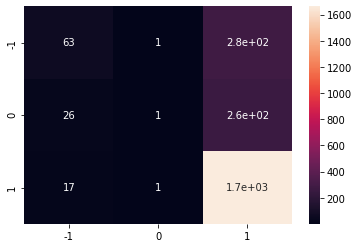

2-gram:
	Max accuracy: 0.7438338381652964 
	C=0.405


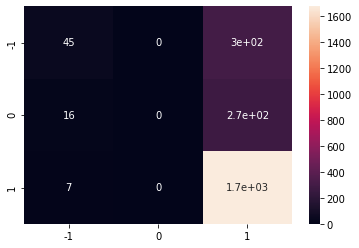

3-gram:
	Max accuracy: 0.7425356988316746 
	C=5


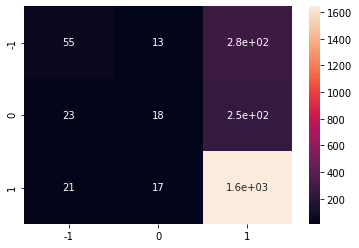

In [3]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for n in [1, 2, 3]:
    max_accuracy = max_accuracy_c = max_accuracy_confusion_matrix = 0
    for c in np.arange(0.005, 1, 0.2).tolist() + np.arange(1, 50, 4).tolist():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=50)
        count_vectorizer = CountVectorizer(ngram_range=(n, n))
        count_vectorizer.fit(X_train)
        X_train = count_vectorizer.transform(X_train)
        X_test = count_vectorizer.transform(X_test)
        
        model = SVC(C=c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_c = c
            max_accuracy_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    print(f"{n}-gram:")
    print("\tMax accuracy:", max_accuracy, f"\n\tC={max_accuracy_c}")
    sns.heatmap(max_accuracy_confusion_matrix, annot=True, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.show()

Still far from satisfactory (although much better than the lexicon based methods)\
The prediction is skewed towards the positive class, probably because the training data is imbalanced towards the positive class\
Let's train the model again after undersampling the training data

Acknowledgements:\
Thanks [Judy](https://medium.com/@judytraj007) for the [tutorial](https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36)

1-gram:
	Max accuracy: 0.5417568152315015 
	C=5


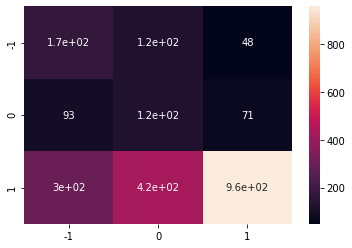

2-gram:
	Max accuracy: 0.40025962786672437 
	C=9


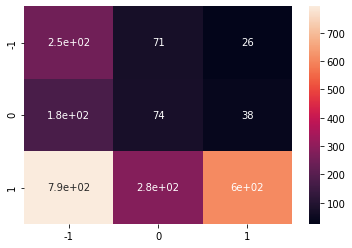

3-gram:
	Max accuracy: 0.30203375162267415 
	C=9


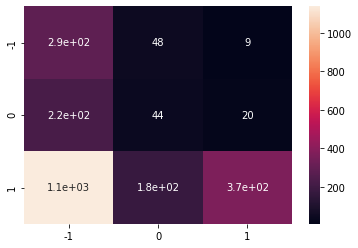

In [4]:
from sklearn.utils import resample

for n in [1, 2, 3]:
    max_accuracy = max_accuracy_c = max_accuracy_confusion_matrix = 0
    for c in np.arange(0.005, 1, 0.2).tolist() + np.arange(1, 50, 4).tolist():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=50)
        
        # Undersampling the training data
        train = pd.concat([X_train, y_train], axis=1)
        train_positive = train[train["Sentiment"] == 1]
        train_neutral = train[train["Sentiment"] == 0]
        train_negative = train[train["Sentiment"] == -1]
        train_positive_resampled = resample(train_positive, n_samples=len(train_negative), random_state=70)
        train_resampled = pd.concat([train_positive_resampled, train_neutral, train_negative])
        X_train = train_resampled["Title"]
        y_train = train_resampled["Sentiment"]

        count_vectorizer = CountVectorizer(ngram_range=(n, n))
        count_vectorizer.fit(X_train)
        X_train = count_vectorizer.transform(X_train)
        X_test = count_vectorizer.transform(X_test)

        model = SVC(C=c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_c = c
            max_accuracy_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    print(f"{n}-gram:")
    print("\tMax accuracy:", max_accuracy, f"\n\tC={max_accuracy_c}")
    sns.heatmap(max_accuracy_confusion_matrix, annot=True, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.show()

Undersampling worsens the situation in this case, maybe more training data is needed